In [5]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import qiskit as qk
from qiskit.circuit.library import MCMT

from context import tools as t

plt.style.use('science')

In [10]:
def filterdict(dic, f):
    newdic = {}
    for key, value in dic.items():
        if f(value) == True:
            newdic[key] = value
    return newdic

def a_estimate(bit_str):
    return (np.sin(np.pi*t.bit_index(bit_str)/2**4))**2

In [2]:
# build A
qr, qc = t.circ(2)
qc.h(0)
qc.cnot(0, 1)
A_circ = deepcopy(qc)
B_circ = deepcopy(qc)

qr, qc = t.circ(4)
qc.compose(A_circ, qr[:2], inplace=True)
qc.compose(B_circ, qr[-2:], inplace=True)
qc.cnot(0, 3)
qc.h(0)
U_circ = deepcopy(qc)
# print(U_circ.draw())

def esti_arr(U_circ, desired_str, M, ibm=False):
    n_qubits = U_circ.num_qubits
    U_gate = U_circ.to_gate(label='U')
    Q_ctrl_gate = t.Q_circuit(U_gate, desired_str)
    qr, cr, qc = t.circ_measured(M+n_qubits, M)
    qc.h(qr[:M])
    qc.compose(U_gate, qr[M:], inplace=True)
    
    wires = lambda i: [qr[M-i-1]] + qr[M:]
    
    for i, Q_power in enumerate(t.powers(Q_ctrl_gate, M)):
        qc.compose(Q_power.to_gate(label=f'Q^{i+1}').control(), wires(i), inplace=True)
#         qc.compose(Q_power.control(), wires(i), inplace=True)
    qc.barrier()
    qc.h(qr[:M])
    qc.measure(qr[:M], cr)
    print(qc.draw())
    counts = t.get_counts(qc)
    return counts

c = esti_arr(U_circ, '0.10', 6)

     ┌───┐                                                  ░ ┌───┐┌─┐         »
q_0: ┤ H ├────────────────────────────────────────────■─────░─┤ H ├┤M├─────────»
     ├───┤                                            │     ░ ├───┤└╥┘┌─┐      »
q_1: ┤ H ├────────────────────────────────────■───────┼─────░─┤ H ├─╫─┤M├──────»
     ├───┤                                    │       │     ░ ├───┤ ║ └╥┘┌─┐   »
q_2: ┤ H ├────────────────────────────■───────┼───────┼─────░─┤ H ├─╫──╫─┤M├───»
     ├───┤                            │       │       │     ░ ├───┤ ║  ║ └╥┘┌─┐»
q_3: ┤ H ├────────────────────■───────┼───────┼───────┼─────░─┤ H ├─╫──╫──╫─┤M├»
     ├───┤                    │       │       │       │     ░ ├───┤ ║  ║  ║ └╥┘»
q_4: ┤ H ├────────────■───────┼───────┼───────┼───────┼─────░─┤ H ├─╫──╫──╫──╫─»
     ├───┤            │       │       │       │       │     ░ ├───┤ ║  ║  ║  ║ »
q_5: ┤ H ├────■───────┼───────┼───────┼───────┼───────┼─────░─┤ H ├─╫──╫──╫──╫─»
     ├───┴┐┌──┴───┐┌──┴───┐┌

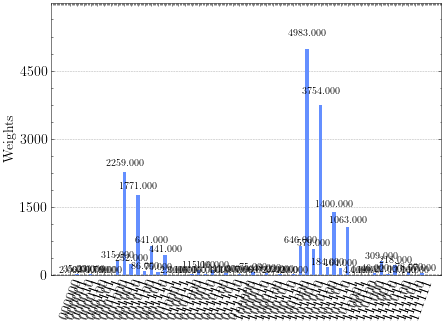

In [9]:
t.plot_weights(c)
plt.show()

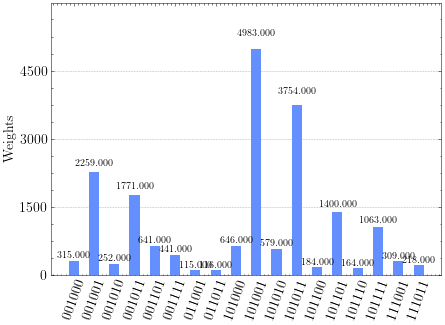

In [8]:
t.plot_weights(filterdict(c, lambda x: x>100))
plt.show()

In [13]:
a_estimate(max(c, key=c.get))/oracle


0.9619397662556438

In [15]:
t.oracle_circuit('0.10').draw()

┌───┐          ┌───┐     
q_0: ┤ X ├───────■──┤ X ├─────
     └───┘       │  └───┘     
q_1: ────────────┼────────────
                 │            
q_2: ────────────■────────────
     ┌───┐┌───┐┌─┴─┐┌───┐┌───┐
q_3: ┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├
     └───┘└───┘└───┘└───┘└───┘

In [17]:
qk.transpile(t.oracle_circuit('0.10')).draw()

┌───┐          ┌───┐     
q_0: ┤ X ├───────■──┤ X ├─────
     └───┘       │  └───┘     
q_1: ────────────┼────────────
                 │            
q_2: ────────────■────────────
     ┌───┐┌───┐┌─┴─┐┌───┐┌───┐
q_3: ┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├
     └───┘└───┘└───┘└───┘└───┘

In [ ]:
t.job_set()

In [21]:
qr, qc = t.circ(4)
qc.compose(t.oracle_circuit('0.10'), qr, inplace=True)
qc.measure_all()
qc.draw()

┌───┐          ┌───┐      ░ ┌─┐         
   q_0: ┤ X ├───────■──┤ X ├──────░─┤M├─────────
        └───┘       │  └───┘      ░ └╥┘┌─┐      
   q_1: ────────────┼─────────────░──╫─┤M├──────
                    │             ░  ║ └╥┘┌─┐   
   q_2: ────────────■─────────────░──╫──╫─┤M├───
        ┌───┐┌───┐┌─┴─┐┌───┐┌───┐ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├─░──╫──╫──╫─┤M├
        └───┘└───┘└───┘└───┘└───┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════╩══╩══╩══╩═
                                     0  1  2  3

In [22]:
t.job_set(qc)

In [23]:
qr, qc = t.circ(5)
qc.compose(t.oracle_ancilla_circuit('0.10'), qr, inplace=True)
qc.measure_all()
qc.draw()

┌───┐     ┌───┐ ░ ┌─┐            
   q_0: ┤ X ├──■──┤ X ├─░─┤M├────────────
        └───┘  │  └───┘ ░ └╥┘┌─┐         
   q_1: ───────┼────────░──╫─┤M├─────────
               │        ░  ║ └╥┘┌─┐      
   q_2: ───────■────────░──╫──╫─┤M├──────
        ┌───┐  │  ┌───┐ ░  ║  ║ └╥┘┌─┐   
   q_3: ┤ X ├──■──┤ X ├─░──╫──╫──╫─┤M├───
        └───┘┌─┴─┐└───┘ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ─────┤ X ├──────░──╫──╫──╫──╫─┤M├
             └───┘      ░  ║  ║  ║  ║ └╥┘
meas: 5/═══════════════════╩══╩══╩══╩══╩═
                           0  1  2  3  4

In [24]:
t.job_set(qc)